# exp 7 인물사진을 만들어 보자 1/3 (인물사진-)
## 작업파일 링크 :&nbsp;&nbsp;&nbsp;[<인물>](https://github.com/yssihn/Aiffel/blob/master/exp_07_00.ipynb)&nbsp;&nbsp;&nbsp;[<고양이>](https://github.com/yssihn/Aiffel/blob/master/exp_07_01.ipynb)&nbsp;&nbsp;&nbsp;[<배경크로마키>](https://github.com/yssihn/Aiffel/blob/master/exp_07_02.ipynb)&nbsp;&nbsp;&nbsp;[<회고>](https://github.com/yssihn/Aiffel/blob/master/exp_07_03.ipynb)

### 평가기준
**1. 인물모드 사진을 성공적으로 제작하였다.**<br>
아웃포커싱 효과가 적용된 <span style="color:blue">딸의 인물모드</span> 사진과 <span style="color:blue">고양이</span> 사진, <span style="color:blue">배경전환크로마키</span>사진을 각각 1장 이상 성공적으로 제작하였다.<br>
**=> 성공적 제작 완료 (위의 링크로 확인 바람)**

**2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.**<br>
인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.<br>
**=> [회고페이지](https://github.com/yssihn/Aiffel/blob/master/exp_07_03.ipynb)에 문제확이 한 사진 올림**

**3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.**<br>
추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.<br>
**=> [회고페이지](https://github.com/yssihn/Aiffel/blob/master/exp_07_03.ipynb)에 개선 솔루션 기술**
***


***
### 1. 관련 모둘 임포트 및 이미지 불러오기

***

(1440, 1440, 3)


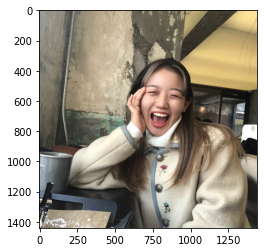

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation # 이건 어디서 받지???? https://github.com/ayoolaolafenwa/PixelLib
from matplotlib import pyplot as plt                # 맥북에서는 conda search로 안나오네... 어찌하지... 다른 방법이 있겠지.


# 본인이 선택한 딸의 이미지를 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_daughter.jpeg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

***
### 2. pixellib에서 제공하는 모델을 사용하자
***

In [3]:
# 모델을 불러와 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드 및 모델을 저장 합니다. 
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f2e2e75a040>)

In [4]:
# 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성합니다.

# 세그멘테이션 모델을 생성한다.
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file)

# 모델이미지를 입력 한다. 
# segmentAsPascalvoc라는 함수는 PASCAL VOC 데이터로 학습된 모델을 이용한다.
segvalues, output = model.segmentAsPascalvoc(img_path)

# segvalues는 뻡아낼 수 있는 것 중에 뽑아낸 이미지의 id와 mask값이 들어있다
# output에는 뽑아낸 이미지들이 색깍별로 나누어져있는 이미지가 합쳐져 있다. 

print("==>💋<==")

==>💋<==


In [5]:
# background : 0, cat : 8, person : 15
LABEL_NAMES = [
    'background', 
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
    'bus', 'car', 'cat', 'chair', 'cow', 
    'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

len(LABEL_NAMES)


21

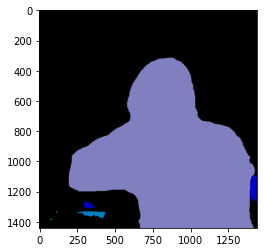

In [6]:
# 아웃풋의 이미지는 아래와 같이 추출한 이미지는 각가의 색으로 표현 되어있고 
# 나머지 이미지는 검은 색으로 masking 되어 있다. 이것을 background(0)으로 인식 하고 있다. 
plt.imshow(output)
plt.show()

In [7]:
# 뽑아낸 이미지의 인덱스 값과 각각의 이미지의 masking정보를 가지고 있다. 
segvalues

{'class_ids': array([ 0,  9, 11, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [8]:
# 뽑아낸 이미지의 이름은 LABEL_NMAE에서 확인 할 수 있다. 
# 여기에서는 4가지 background, 의자, 테이블, 사람 을 식별 하였다. 
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
diningtable
person


In [9]:
# 아래 코드를 이해하지 않아도 좋습니다. PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# colormap은 256가지의 색이 정의 되어있지만 인식할 수 있는 이미지는 20가지 이고 
# 그중에  [0,  9, 11, 15] 이렇게 4가지를 판단 하였고, 
# 판단한 각각의 이미지들의 색은 인덱스 값  [0,  9, 11, 15]에 있는 색으로 표현 하였다. 
colormap[:20]
# len(colormap)

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [10]:
# person(사람)의 indes값은 15 이다. LABEL_NAMES 확인 할 것!
colormap[15] # BGR 값이다. 사용하기 전에 RGB로 빠꾸어서 사용하자.

array([192, 128, 128])

In [11]:
# 주의 !!! 
# output 이미지는 BGR 순서로 채널이 배치가 되어 있음. 
# colormap은 RGB 순서이고요.
seg_color = (128,128,192)


(1440, 1440)


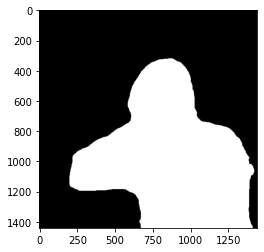

In [12]:
# seg_color로만 이루어진 마스크를 만들자

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1) # axis => 해당 차원의 축을 의미하면 -1은 가장 마직막 차원을 의미한다. 여기서는 2 이다.
                                             # 왜사용해야만 하는 지는 잘 모르겠다. 
                                             # 아웃풋 이미지에서 사람모양만 추출한 seg_color를 비교하여 색이 같은 뿐만 true로 걸러서
                                             # seg_map에 저장 한다. 
print(seg_map.shape) 
# print(seg_map) 

plt.imshow(seg_map, cmap='gray') # imshow는 원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림입니다. 
plt.show()                       # 쉽게말하면 원하는 크기의 행렬을만들어서 각 칸을 원하는 색으로 채우는 것입니다. 
                                 # 각 칸을 채우는 방법은 colormap, RGB, RGBA 의 네가지가 있습니다.
                                 # 색을 채울때 seg_map에 있는 값(여기서는 treu,false)에 따라 다른 색을 체워준다. 
                                 # cmap이 'gray'로 되어있는 경우에는 최저는 white 최고는 black으로 그라데이션으로 나누어 있다. 
                                 # 이번 경우는 true or false인 경우이므로 검은 색 흰색으로 구분하여 색을 체운다. 
                                 # cmap이 정해지지 않은 default 값은 "viridis"로 yellow와 purple로 색을 체운다. 

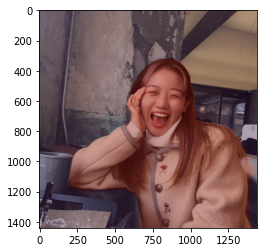

In [17]:
# 원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉬움

img_show = img_orig.copy()

# True, False의 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255 # img_mask에 seg_map의 true, false값을 255,0으로 비꾸어준다. 
                                          # np.uint8 => numpy의 숫자 자료형중의 하나인 0을 포함한 부호가 없는 정수를 2^8만큼 표현 가능.
                                          # seg_map.astype(np.uint8) => seg_map의  True, False 값들이 True는 1, False는 0으로 변경 된다
                                          # seg_map.astype(np.uint8) * 255  => img_mask 의 값을 255,와 0으로 설정 한다.

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_TURBO) # 색상 맵 플래그 https://076923.github.io/docs/ColormapTypes

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

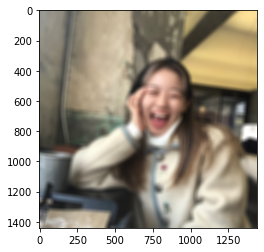

In [18]:
# 블러 효과 주기 (아웃포커싱)
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (33,33))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

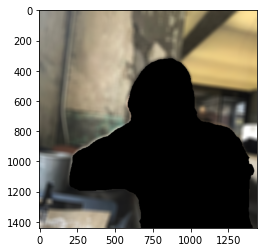

In [14]:
# 블러된 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

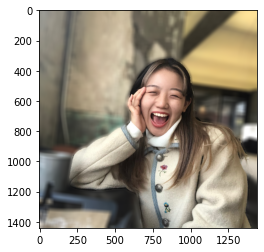

In [15]:
# 이미지 합치기 => 원본이미지(사람) + 블러이미지(배경) 

# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다. 
# np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용하였음.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

***
## 작업파일 링크 : &nbsp;&nbsp; [<인물>](https://github.com/yssihn/Aiffel/blob/master/exp_07_00.ipynb)&nbsp;&nbsp;&nbsp;[<고양이>](https://github.com/yssihn/Aiffel/blob/master/exp_07_01.ipynb)&nbsp;&nbsp;&nbsp;[<배경크로마키>](https://github.com/yssihn/Aiffel/blob/master/exp_07_02.ipynb)&nbsp;&nbsp;&nbsp;[<회고>](https://github.com/yssihn/Aiffel/blob/master/exp_07_03.ipynb)